In [1]:
import os
import sys
import random
import json
import collections
import re
from itertools import combinations

import pandas as pd
import numpy as np
import scipy
import statsmodels
from tqdm import trange, tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


pd.options.display.max_columns = 999

pd.options.display.max_rows = 100

sns.set()
plt.rcParams["figure.figsize"] = (10,7)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sigmod_src.make_dataset import make_specs_dataset
from sigmod_src.preprocessing import preprocess_specs_dataset
from sigmod_src.pipeline import LGBMPipeline
from sigmod_src.utils import get_additional_labels, make_classes_df

In [4]:
LG_LABELS_PATH = '../data/raw/sigmod_large_labelled_dataset.csv'
SPECS_PATH = '../data/raw/2013_camera_specs/'

# Load labels df

In [5]:
labels_df = pd.read_csv(LG_LABELS_PATH)
labels_df.shape

(297651, 3)

In [7]:
labels_df[labels_df.label==1].shape

(44039, 3)

# Load specs df

In [6]:
specs_dataset_src = make_specs_dataset(SPECS_PATH)

In [10]:
specs_dataset_src.shape

(29787, 7)

In [26]:
specs_df = preprocess_specs_dataset(specs_dataset_src)

Dropping 0 known non-camera brand specs
Dropping 2308 camera bag specs
Warning, dropped 9 rows containing null page titles


In [27]:
specs_df.shape

(27470, 10)

In [28]:
specs_df.sample(10)

,spec_id,page_title,brand,model,type,megapixels,all_text,page_title_stem,all_text_stem,site
17645,www.buzzillions.com//1004,pentax k2000 slr digital review pentax k2000 1...,pentax,None,None,10-mp,pentax k2000 slr digital review pentax k2000 1...,pentax k2000 slr digit review pentax k2000 10 ...,pentax k2000 slr digit review pentax k2000 10 ...,www.buzzillions.com
23199,www.alibaba.com//25142,hd 720p bullet hikvision nvr ip ds-2cd2212-i5 ...,None,None,None,1-3-mp,hd 720p bullet hikvision nvr ip ds-2cd2212-i5 ...,hd 720p bullet hikvis nvr ip ds-2cd2212-i5 hik...,hd 720p bullet hikvis nvr ip ds-2cd2212-i5 hik...,www.alibaba.com
20508,www.alibaba.com//29507,ds-2cd2532f-i full hd ip hikvision mini ir dom...,None,None,None,None,ds-2cd2532f-i full hd ip hikvision mini ir dom...,ds-2cd2532f-i full hd ip hikvis mini ir dome f...,ds-2cd2532f-i full hd ip hikvis mini ir dome f...,www.alibaba.com
29129,cammarkt.com//61,cammarkt nikon d610 24-3-mp cmos fx-format dig...,nikon,d610,dslr,24-3-mp,cammarkt nikon d610 24-3-mp cmos fx-format dig...,cammarkt nikon d610 24-3-mp cmos fx-format dig...,cammarkt nikon d610 24-3-mp cmos fx-format dig...,cammarkt.com
28961,www.gosale.com//411,panasonic lumix dmc-zs7 12-1-mp digital sale 5...,panasonic,None,None,12-1-mp,panasonic lumix dmc-zs7 12-1-mp digital sale 5...,panason lumix dmc-zs7 12-1-mp digit sale 599 00,panason lumix dmc-zs7 12-1-mp digit sale 599 0...,www.gosale.com
3393,www.ebay.com//60384,canon sd870 face reconditioned dependable shar...,canon,sd870,point shoot,8-mp,canon sd870 face reconditioned dependable shar...,canon sd870 face recondit depend sharp clear p...,canon sd870 face recondit depend sharp clear p...,www.ebay.com
4371,www.ebay.com//43936,nikon canera cool pix 2100,nikon,None,None,None,nikon canera cool pix 2100 nikon may signs cos...,nikon canera cool pix 2100,nikon canera cool pix 2100 nikon may sign cosm...,www.ebay.com
19597,www.shopmania.in//1327,samsung pl200 digital prices shopping comparis...,samsung,pl200,compact,2-mp,samsung pl200 digital prices shopping comparis...,samsung pl200 digit price shop comparison sams...,samsung pl200 digit price shop comparison sams...,www.shopmania.in
22619,www.alibaba.com//26891,ds-2cd2012-i hikvision ir network ip monitorin...,None,None,None,None,ds-2cd2012-i hikvision ir network ip monitorin...,ds-2cd2012-i hikvis ir network ip monitor soft...,ds-2cd2012-i hikvis ir network ip monitor soft...,www.alibaba.com
26769,www.alibaba.com//28662,hikvision security ds-2cd4332fwd-i 3-mp wdr hi...,None,None,None,3-mp,hikvision security ds-2cd4332fwd-i 3-mp wdr hi...,hikvis secur ds-2cd4332fwd-i 3-mp wdr hikvis s...,hikvis secur ds-2cd4332fwd-i 3-mp wdr hikvis s...,www.alibaba.com


In [29]:
specs_df.index = specs_df.spec_id

In [30]:
sample = specs_df.sample(5)
sample[['spec_id', 'page_title_stem', 'brand', 'model', 'type']].values

array([['www.ebay.com//59828', 'olympus x 42 12-0-mp digit pink',
        'olympus', 'x42', 'point shoot'],
       ['www.pricedekho.com//1016',
        'nikon coolpix p530 point shoot india offer full specif pricedekho com',
        'nikon', 'p530', 'point shoot'],
       ['buy.net//5758',
        'fujifilm blower finepix jx680-16-mp compact 3 lcd 5x optic zoom 4608 x 3440 imag 1280 x 720 video pictbridg hd movi mode comparison net',
        'fujifilm', 'jx680', 'compact'],
       ['www.eglobalcentral.co.uk//74',
        'nikon af- dx nikkor 18-140mm f 3 5-5 6g ed vr lens', 'nikon',
        None, None],
       ['www.ebay.com//46208',
        'samsung st seri st65 14-2-mp digit 8806071373270', 'samsung',
        'st65', 'point shoot']], dtype=object)

In [35]:
specs_df.brand.value_counts(dropna=False)

NaN          5918
canon        5487
nikon        4720
sony         3442
fujifilm     1620
olympus      1459
panasonic    1284
samsung      1042
kodak         767
pentax        665
casio         217
leica         216
gopro         206
vivitar       196
polaroid      120
ricoh         111
Name: brand, dtype: int64

In [32]:
specs_df.model.value_counts(dropna=False)[:10]

NaN      13439
t3i        210
d3200      195
60d        167
d3100      156
70d        146
d5200      146
d7000      136
d5100      136
1100d      131
Name: model, dtype: int64

In [33]:
specs_df.type.value_counts(dropna=False)[:10]

NaN            10701
point shoot     7769
dslr            5576
compact         1235
mirrorless      1115
underwater       602
bridge           472
Name: type, dtype: int64

In [34]:
specs_df.megapixels.value_counts(dropna=False)[:10]

NaN        7461
16-mp      1752
2-mp       1678
12-1-mp     881
3-mp        867
18-mp       767
1-3-mp      707
8-mp        694
5-mp        689
1-mp        663
Name: megapixels, dtype: int64

In [36]:
specs_df.to_csv('../data/processed/specs.csv', index=None)

# Test pipeline

In [37]:
model = LGBMPipeline(specs_df, labels_df)

In [38]:
model.labels

array([1, 0, 0, ..., 0, 0, 0])

In [39]:
model.precompute()

1365it [00:00, 6439.02it/s]
100%|██████████| 14/14 [00:00<00:00, 14.37it/s]


In [40]:
x = model.make_X([0, 2], [1, 3])
x.shape

(2, 25)

In [41]:
model.train(precompute=False)

Precomputing
Making features
Making features for additional_labels
Fitting model


In [42]:
pred_train = model.clf.predict(model.train_X)

print('Train F1', f1_score(model.train_Y, pred_train))
print(classification_report(model.train_Y, pred_train))

Train F1 0.9197842608482472
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    110212
           1       1.00      0.85      0.92     44039

    accuracy                           0.96    154251
   macro avg       0.97      0.93      0.95    154251
weighted avg       0.96      0.96      0.96    154251



In [43]:
additional_left_spec_idx = model.specs_id_to_idx[model.additional_df['left_spec_id']]
additional_right_spec_idx = model.specs_id_to_idx[model.additional_df['right_spec_id']]

additional_X = model.make_X(additional_left_spec_idx, additional_right_spec_idx)

additional_Y = model.additional_df.label

pred_additional = model.clf.predict(additional_X)

print('F1 on additional labels', f1_score(additional_Y, pred_additional))
print(classification_report(additional_Y, pred_additional))

F1 on additional labels 0.5419793004223457
              precision    recall  f1-score   support

           0       0.90      0.99      0.95    519208
           1       0.90      0.39      0.54     90159

    accuracy                           0.90    609367
   macro avg       0.90      0.69      0.74    609367
weighted avg       0.90      0.90      0.89    609367



Sanity check passed

# Feature importance

In [146]:
import shap

In [112]:
explainer = shap.TreeExplainer(model.clf)

In [113]:
shap_values = explainer.shap_values(model.train_X)

In [114]:
feature_names = ['n_common_tokens', 
                    'n_common_tokens_normed',
                    'sum_len_common_tokens',
                    'special_sum_len_common_tokens',
                    'special_n_common_tokens',
                    'number_sum_len_common_tokens',
                    'number_n_common_tokens',

                    'n_common_symbols_models', 'same_model',

                    'n_common_symbols_types', 'same_type',

                    'n_common_symbols_megapixels', 'same_megapixels',

                    'cosine_sim_tfidf',
                    'lev_ratios',

                    'n_common_neighboors', 'n_common_neighboors_normed',

                    'jaccard_sim',
                    'n_common_symbols',


                    'site_left', 'site_right', 


                    'sum_len_common_tokens_all_text', 'n_common_tokens_all_text',
                    'special_n_common_tokens_all_text', 'special_n_common_tokens_all_text_normed',


                   'same_site',
                   ]

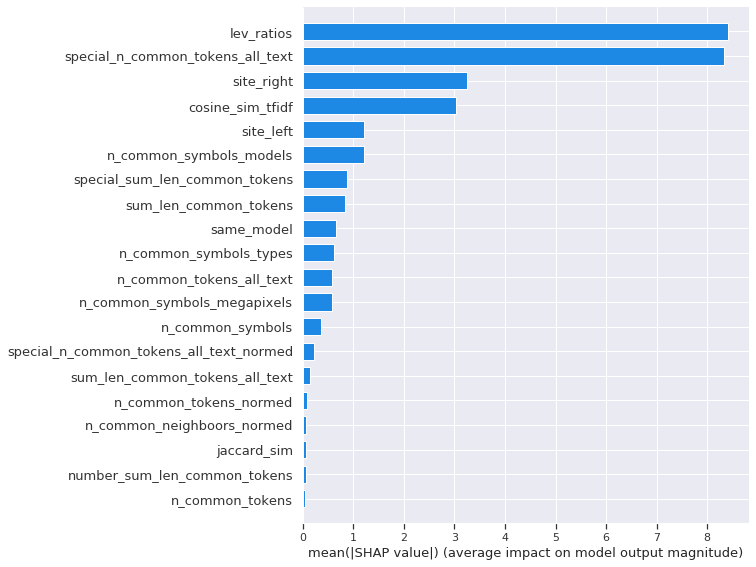

In [115]:
shap.summary_plot(shap_values, model.train_X, plot_type="bar", feature_names=feature_names)

# Submit

In [44]:
model.make_submission()

100%|██████████| 16/16 [1:46:15<00:00, 220.25s/it]  


In [45]:
submit_df = pd.read_csv('../data/submit/submit.csv')
submit_df.shape

(1849698, 2)

In [46]:
specs_df.index = specs_df.spec_id

In [48]:
row = submit_df.sample(1)

print('Left\n', specs_df.loc[row.left_spec_id].page_title.values[0])
print('')
print('Right\n', specs_df.loc[row.right_spec_id].page_title.values[0])

Left
 canon powershot digital elph sd1300 ixus 105 12-1-mp digital

Right
 canon powershot elph 100 hs ixus 115 hs 12-1-mp digital


# CV

In [645]:
def get_split(classes_df, labels_df, test_classes=5):
    classes = classes_df.class_.unique()
    test_classes = np.random.choice(classes, test_classes)
    
    test_spec_ids = classes_df[classes_df.class_.isin(test_classes)].spec_id
    
    test_label_mask = labels_df.left_spec_id.isin(test_spec_ids) | labels_df.right_spec_id.isin(test_spec_ids)
    
    test_idx = np.array(labels_df[test_label_mask].index)
    train_idx = np.array(labels_df[~test_label_mask].index)
    
    return train_idx, test_idx

def evaluate_submit(submit_df, test_labels_df):
    submit_df = submit_df.copy()
    submit_df['label'] = 1
    
    merged = test_labels_df.merge(submit_df, on=['left_spec_id', 'right_spec_id'], how='left', suffixes = ('_true', '_pred'))
    merged['label_pred'] = merged['label_pred'].fillna(0)
    
    tp = merged[(merged.label_true == 1) & (merged.label_pred == 1)]
    tn = merged[(merged.label_true == 0) & (merged.label_pred == 0)]
    
    fp = merged[(merged.label_true == 0) & (merged.label_pred == 1)]
    fn = merged[(merged.label_true == 1) & (merged.label_pred == 0)]
    
    precision = tp.shape[0]/(tp.shape[0]+fp.shape[0])
    recall = tp.shape[0]/(tp.shape[0]+fn.shape[0])
    
    f1 = 2 * (precision * recall)/(precision+recall)
    
    return f1, tp, tn, fp, fn

def cross_validate_pipeline(pipeline_class, specs_df, labels_df, n_folds=5, test_classes=5):
    # Obtain triangles from label and number them
    classes_df = make_classes_df(labels_df)
    folds = []
    submit_fpaths = []
    scores = []
    for i_fold in tqdm(range(n_folds)):
        print('Fold', i_fold)
        labels_train_idx, labels_test_idx = get_split(classes_df, labels_df, test_classes=test_classes)
        folds.append( (labels_train_idx, labels_test_idx) )
        
        train_labels = labels_df.iloc[labels_train_idx].copy()
        test_labels = labels_df.iloc[labels_test_idx].copy()
        
        submit_fpath = f'../data/interim/cv_submit_fold{i_fold}.csv'
        submit_fpaths.append(submit_fpath)
        
        model = pipeline_class(specs_df, train_labels, submit_fpath=submit_fpath)
        print('training model')
        model.train()
        
        print('generating submit')
        model.make_submission()
        
        print('evaluating submit')
        f1score, _, _, _, _ = evaluate_submit(pd.read_csv(model.submit_fpath), test_labels)
        scores.append(f1score)
        print('Score', f1score)
    return folds, submit_fpaths, scores

In [ ]:
# np.random.seed(42)
np.random.seed(None)
folds, submit_fpaths, scores = cross_validate_pipeline(LGBMPipeline, specs_df, labels_df, n_folds=3)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

Fold 0
training model
Precomputing




0it [00:00, ?it/s]

568it [00:00, 5643.74it/s]

865it [00:00, 4439.29it/s]

1187it [00:00, 3984.91it/s]

1399it [00:00, 4161.64it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

 12%|█▏        | 4/34 [00:00<00:03,  8.90it/s]

 56%|█████▌    | 19/34 [00:00<00:01, 11.33it/s]

 79%|███████▉  | 27/34 [00:01<00:00, 15.13it/s]

 91%|█████████ | 31/34 [00:01<00:00, 15.74it/s]

100%|██████████| 34/34 [00:01<00:00, 26.59it/s]

Making features
Making features for additional_labels
Fitting model




  0%|          | 0/58 [00:00<?, ?it/s]

generating submit




  2%|▏         | 1/58 [00:00<00:39,  1.43it/s]

  9%|▊         | 5/58 [06:32<26:23, 29.87s/it]

 10%|█         | 6/58 [06:33<18:17, 21.11s/it]

 22%|██▏       | 13/58 [06:33<11:05, 14.78s/it]

 22%|██▏       | 13/58 [06:50<11:05, 14.78s/it]

 26%|██▌       | 15/58 [07:08<11:13, 15.67s/it]

 31%|███       | 18/58 [07:08<07:19, 11.00s/it]

 40%|███▉      | 23/58 [07:17<04:47,  8.22s/it]

 43%|████▎     | 25/58 [07:17<03:11,  5.80s/it]

 53%|█████▎    | 31/58 [07:57<02:42,  6.01s/it]

 59%|█████▊    | 34/58 [12:47<13:18, 33.27s/it]

 60%|██████    | 35/58 [13:16<12:18, 32.09s/it]

 64%|██████▍   | 37/58 [13:42<09:11, 26.28s/it]

 66%|██████▌   | 38/58 [13:49<06:48, 20.41s/it]

 69%|██████▉   | 40/58 [13:49<04:17, 14.31s/it]

 71%|███████   | 41/58 [13:49<02:51, 10.09s/it]

 74%|███████▍  | 43/58 [14:05<02:22,  9.51s/it]

 81%|████████  | 47/58 [16:12<02:57, 16.16s/it]

 84%|████████▍ | 49/58 [16:12<01:41, 11.33s/it]

 95%|█████████▍| 55/58 [16:13<00:23,  7.96s/it]

100%|██████████| 58/5

evaluating submit
Score 0.5209091803601299
Fold 1
training model
Precomputing




0it [00:00, ?it/s]

521it [00:00, 5205.96it/s]

1033it [00:00, 5178.40it/s]

1399it [00:00, 4914.83it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

 12%|█▏        | 4/34 [00:00<00:03,  9.90it/s]

 56%|█████▌    | 19/34 [00:00<00:01, 12.43it/s]

 79%|███████▉  | 27/34 [00:01<00:00, 16.51it/s]

 91%|█████████ | 31/34 [00:01<00:00, 17.29it/s]

100%|██████████| 34/34 [00:01<00:00, 27.92it/s]

Making features
Making features for additional_labels
Fitting model




  0%|          | 0/58 [00:00<?, ?it/s]

generating submit




  2%|▏         | 1/58 [00:00<00:34,  1.64it/s]

In [18]:
scores

[0.6862745098039216, 0.5894736842105264, 0.6948356807511737]

In [19]:
np.mean(scores)

0.6568612915885406

## Test evaluation scheme

In [ ]:

    
    
test_labels_df = labels_df.iloc[folds[0][1]]
submit_df = pd.read_csv(submit_fpaths[0])

score, tp, tn, fp, fn = evaluate_submit(submit_df, test_labels_df)
score

Test one true positive

In [ ]:
tp.head()

In [ ]:
test_labels_df[test_labels_df.label == 1][test_labels_df.left_spec_id == 'www.ebay.com//24206']

In [ ]:
submit_df[(submit_df.left_spec_id == 'www.ebay.com//24206') & (submit_df.right_spec_id == 'www.priceme.co.nz//54')]

Pass

Check one tn

In [ ]:
tn.head()

In [ ]:
test_labels_df[test_labels_df.label == 0][test_labels_df.left_spec_id == 'www.ebay.com//42074'][test_labels_df.right_spec_id == 'www.ebay.com//47107']

In [ ]:
submit_df[submit_df.left_spec_id == 'www.ebay.com//42074'][submit_df.right_spec_id == 'www.ebay.com//47107']

Pass

Check one fp

In [ ]:
fp.head()

In [ ]:
test_labels_df[test_labels_df.label == 0][test_labels_df.left_spec_id == 'www.ebay.com//42074'][test_labels_df.right_spec_id == 'www.ebay.com//54040']

In [ ]:
submit_df[submit_df.left_spec_id == 'www.ebay.com//42074'][submit_df.right_spec_id == 'www.ebay.com//54040']

Pass

Check one fn

In [ ]:
fn.head()

In [ ]:
test_labels_df[test_labels_df.label == 1][test_labels_df.left_spec_id == 'www.ebay.com//54040'][test_labels_df.right_spec_id == 'www.ebay.com//54457']

In [ ]:
submit_df[submit_df.left_spec_id == 'www.ebay.com//54040'][submit_df.right_spec_id == 'www.ebay.com//54457']

pass